In [2]:
import pandas as pd
import numpy as np
from collections import Counter

In [3]:
from matplotlib import rc
import matplotlib.pyplot as plt

font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

%matplotlib inline

In [4]:
pd.set_option('display.max_rows', 15)

# Загрузка данных

In [5]:
train_urls = pd.read_table('url_domain_train', names=['user_id', 'url', 'visits_count'])
test_urls = pd.read_table('url_domain_test', names=['user_id', 'url', 'visits_count'])

train_titles = pd.read_table('title_unify_train', names=['user_id', 'title', 'visits_count'])
test_titles = pd.read_table('title_unify_test', names=['user_id', 'title', 'visits_count'])

train_ages = pd.read_table('age_profile_train', names=['user_id', 'age'])

In [5]:
train_titles.shape, train_urls.shape, train_ages.shape

((5850389, 3), (2046869, 3), (118679, 2))

In [6]:
test_titles.shape, test_urls.shape

((2303479, 3), (613388, 3))

# Фичи

## Возраст(Target value)

In [7]:
len(train_ages['age'].unique())

99

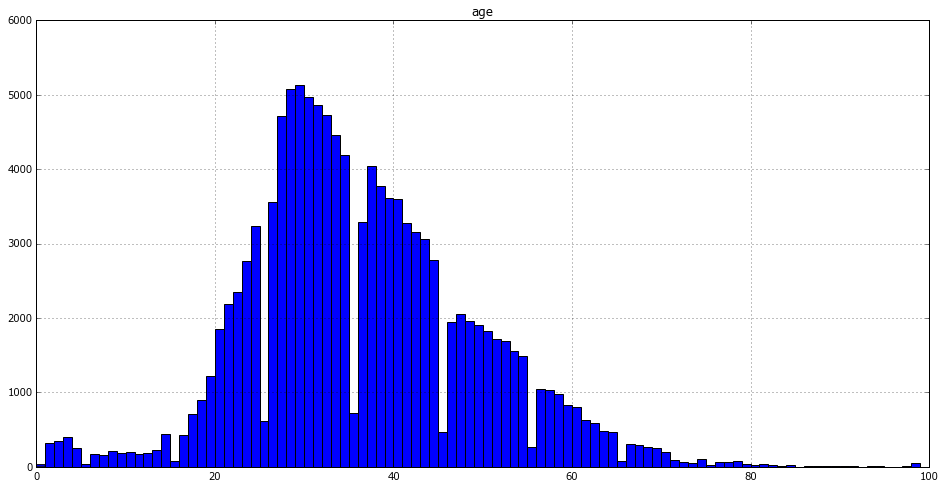

In [64]:
train_ages.hist(column='age', figsize=(16, 8), bins=99)
plt.show()

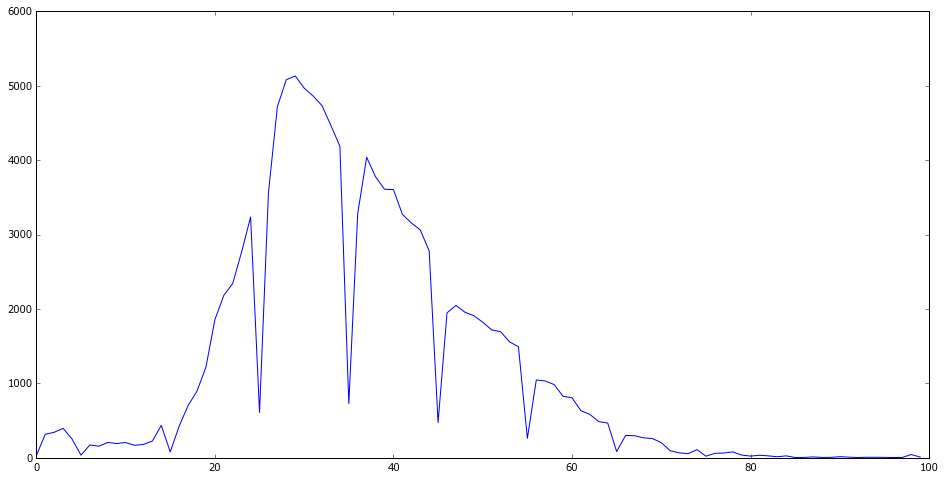

In [65]:
ages_count = train_ages.pivot_table(index='age', aggfunc='count')

plt.figure(figsize=(16, 8))
plt.plot(ages_count.index, ages_count.values[:, 0])
plt.show()

## Активность

In [114]:
activity_titles_train.shape, activity_urls_train.shape, train_ages.shape

((114156,), (118603,), (118679, 2))

In [16]:
def get_activity_pivot(urls, titles, ages, activity_metric=lambda g: g['visits_count'].sum()):
    activity_urls = urls.groupby('user_id').apply(activity_metric)
    activity_titles = titles.groupby('user_id').apply(activity_metric)
    
    activity = pd.concat([activity_titles, activity_urls],
                     axis=1, join_axes=[ages.user_id])
    activity['age'] = ages['age'].values
    activity = activity.fillna(0)
    activity.columns = ['titles', 'urls', 'age']
    
    activity_pivot = activity.pivot_table(index=['age'], values=['titles', 'urls'], aggfunc=[np.mean, np.std])
    
    return activity_pivot

def plot_activity_pivot(activity_pivot, print_std=False):
    plt.figure(figsize=(16, 8))
    plt.plot(activity_pivot.index, activity_pivot['mean']['titles'], 'b',
             activity_pivot.index, activity_pivot['mean']['urls'], 'r')
    plt.xlim(0, 80)
    plt.show()
    
    if print_std:
        plt.figure(figsize=(16, 8))
        plt.plot(activity_pivot.index, activity_pivot['std']['titles'], 'b',
                 activity_pivot.index, activity_pivot['std']['urls'], 'r')
        plt.xlim(0, 80)
        plt.show()

In [6]:
def count_total_visits(df):
    array = df['visits_count'].values
    return array.sum()

def count_not_ones(df):
    array = df['visits_count'].values
    return len(array[array > 2])

def count_sum_not_ones(df):
    array = df['visits_count'].values
    return sum(array[array > 2])

def count_sum_ones(df):
    array = df['visits_count'].values
    return sum(array[array == 1])

def count_visits_std(df):
    array = df['visits_count'].values
    return np.std(array)

def count_visits_max(df):
    array = df['visits_count'].values
    return max(array)

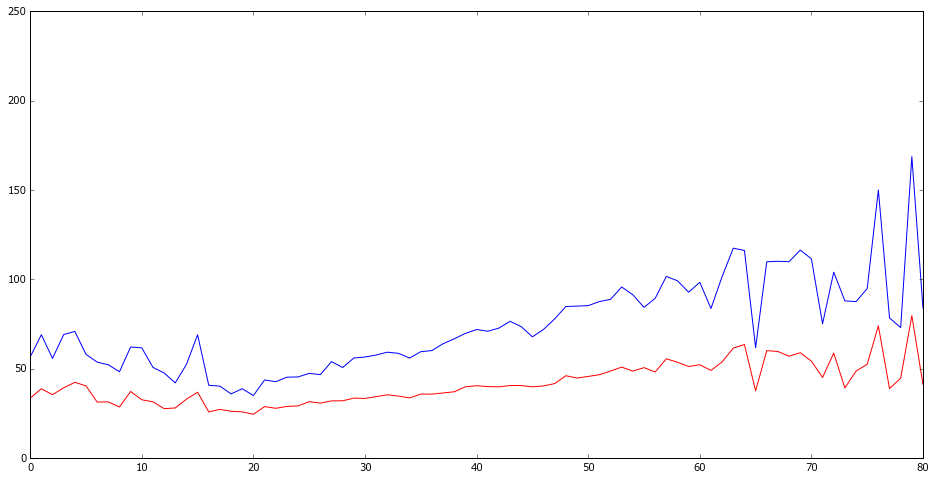

In [101]:
activity_pivot = get_activity_pivot(train_urls, train_titles, train_ages, activity_metric=count_total_visits)
plot_activity_pivot(activity_pivot)

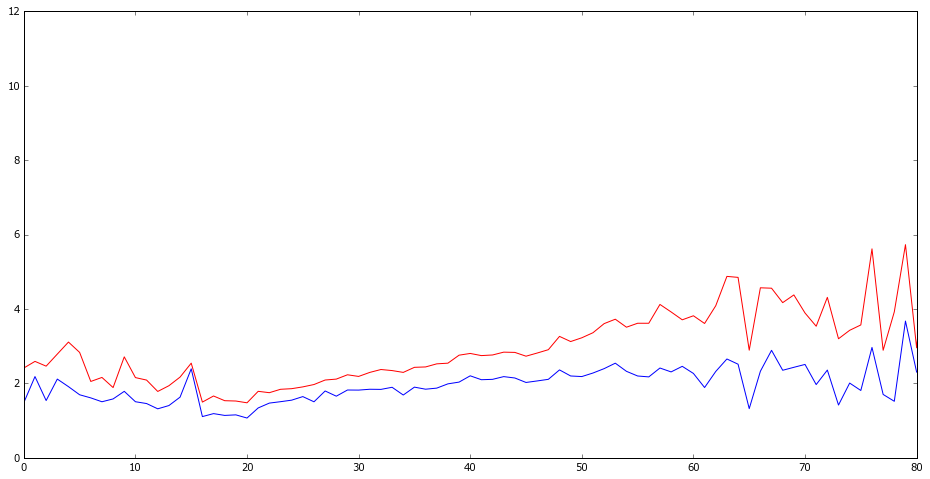

In [9]:
activity_pivot = get_activity_pivot(train_urls, train_titles, train_ages, activity_metric=count_not_ones)
plot_activity_pivot(activity_pivot)

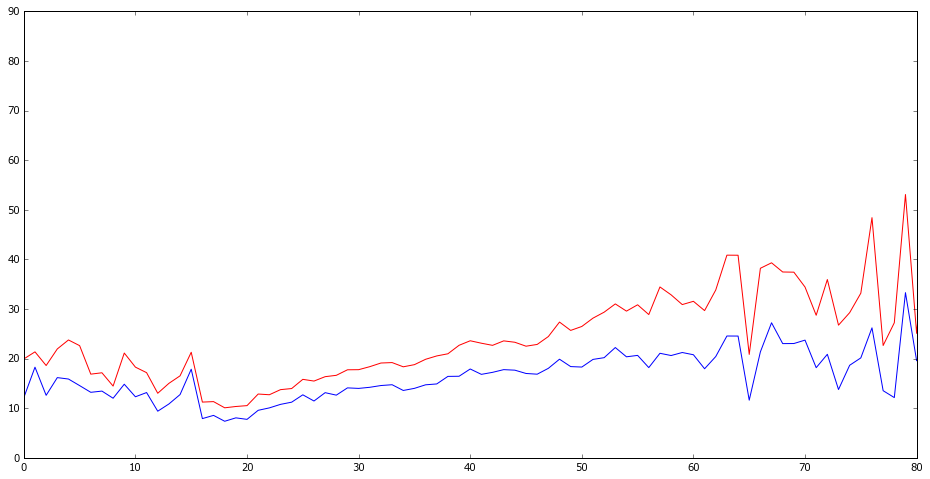

In [10]:
activity_pivot = get_activity_pivot(train_urls, train_titles, train_ages, activity_metric=count_sum_not_ones)
plot_activity_pivot(activity_pivot)

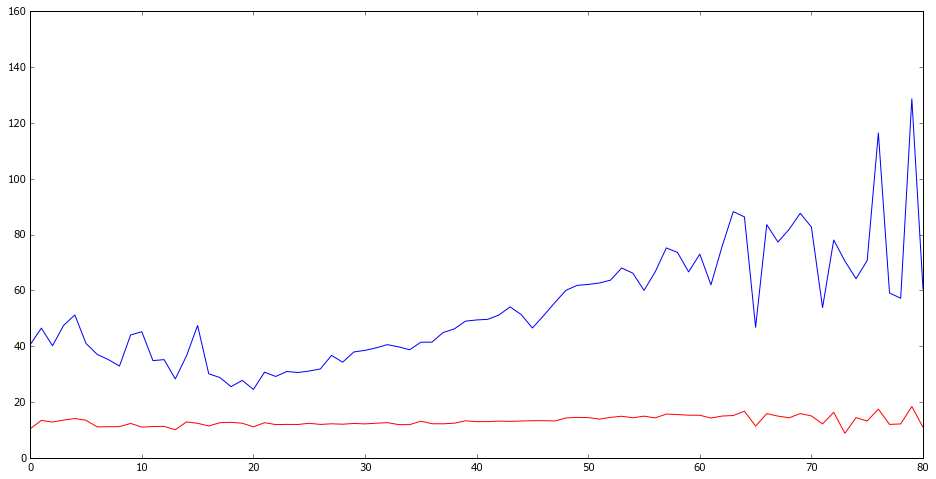

In [12]:
activity_pivot = get_activity_pivot(train_urls, train_titles, train_ages, activity_metric=count_sum_ones)
plot_activity_pivot(activity_pivot)

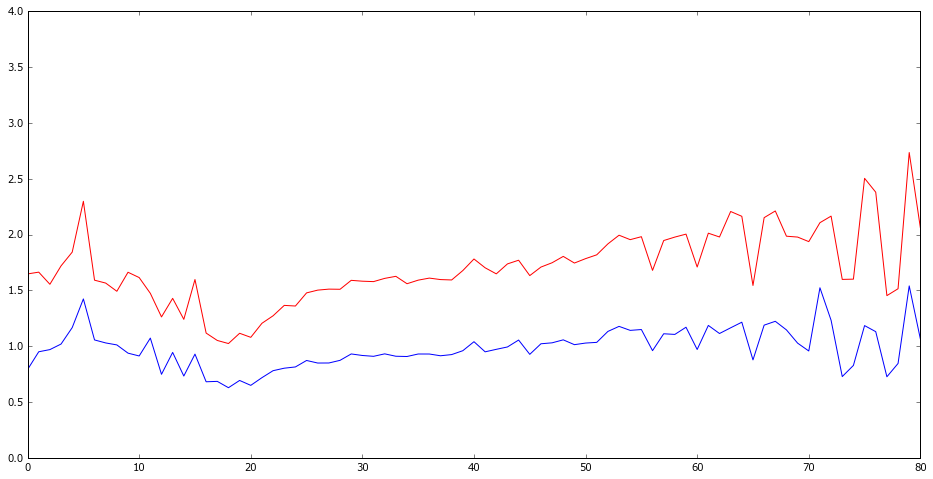

In [13]:
activity_pivot = get_activity_pivot(train_urls, train_titles, train_ages, activity_metric=count_visits_std)
plot_activity_pivot(activity_pivot)

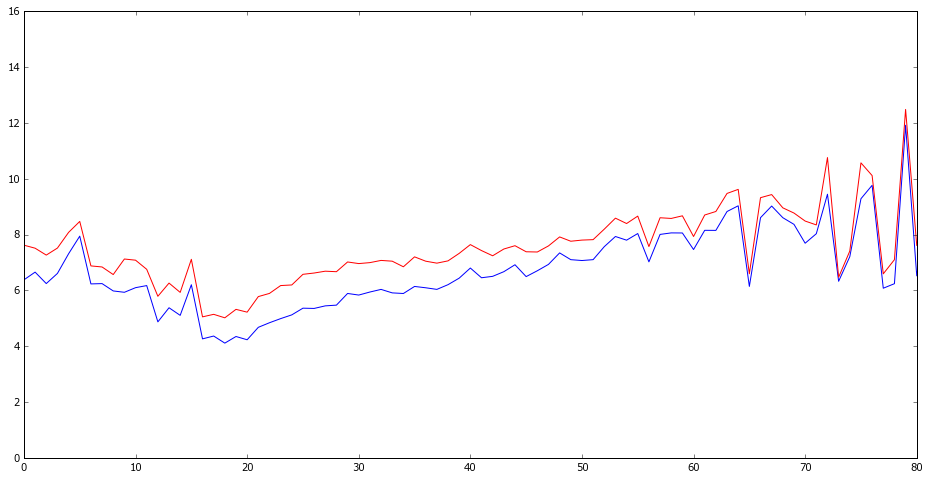

In [14]:
activity_pivot = get_activity_pivot(train_urls, train_titles, train_ages, activity_metric=count_visits_max)
plot_activity_pivot(activity_pivot)

## Адреса(urls)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

In [8]:
def url_cutter(url):
    *other_domains, upper_domain, lower_domain = url.split('.')
    return '.'.join([upper_domain, lower_domain])

In [ ]:
urls = train_urls.copy()
urls_grouped = urls.groupby('user_id')
users_urls = urls_grouped.apply(lambda g: g['url'])
users_urls = [users_urls[user_id].values if user_id in users_urls else [] for user_id in train_ages['user_id'].values]
users_urls = [[url_cutter(url) for url in user_urls] for user_urls in users_urls]
users_urls = [list(np.unique(user_urls)) for user_urls in users_urls]

In [13]:
test_urls_cutted = test_urls['url'].apply(url_cutter).values
urls_cutted = train_urls['url'].apply(url_cutter).values
urls_counter = Counter([url for user_urls in users_urls for url in user_urls])
urls_counter = {url: count for url, count in urls_counter.items() if count>300 and url in test_urls_cutted}

In [14]:
len(urls_counter)

662

In [15]:
std_set = dict()
count = 0
for url in urls_counter.keys():
    users_ids = train_urls[urls_cutted == url]['user_id']
    ages = train_ages[train_ages['user_id'].isin(users_ids)]['age']
    stats = ages.std(), ages.mean(), urls_counter[url]
    std_set[url] = stats
    
    if not count % 100:
        print(count)
    count += 1

0
100
200
300
400
500
600


In [17]:
print('Самый маленький разброс возрастов')
indexes = np.argsort([value[0] for key, value in std_set.items()])
for url in np.array(list(std_set.keys()))[indexes[:15]]:
    print(url, ': ', std_set[url])
    
print('\n\nСамый большой разброс возрастов')
indexes = np.argsort([value[0] for key, value in std_set.items()])
for url in np.array(list(std_set.keys()))[indexes[-15:]]:
    print(url, ': ', std_set[url])
    
print('\n\nСамый маленький средний возраст')
indexes = np.argsort([value[1] for key, value in std_set.items()])
for url in np.array(list(std_set.keys()))[indexes[:15]]:
    print(url, ': ', std_set[url])
    
print('\n\nСамый большой средний возрат')
indexes = np.argsort([value[1] for key, value in std_set.items()])
for url in np.array(list(std_set.keys()))[indexes[-15:]]:
    print(url, ': ', std_set[url])
    
print('\n\nСамые популярные')
indexes = np.argsort([value[2] for key, value in std_set.items()])
for url in np.array(list(std_set.keys()))[indexes[-15:]]:
    print(url, ': ', std_set[url])

Самый маленький разброс возрастов
razvitie-krohi.ru :  (8.539923014148089, 31.144404332129962, 554)
pregnant-club.ru :  (8.806495830924295, 30.0455764075067, 373)
wow-show.ru :  (9.18800948319383, 29.04474272930649, 447)
animespirit.ru :  (9.402166000236452, 27.613636363636363, 308)
mirage.ru :  (9.509895458967152, 29.509915014164307, 353)
loveradio.ru :  (9.555601332689935, 30.00263852242744, 379)
akusherstvo.ru :  (9.604917291071363, 33.46569920844327, 758)
radiorecord.ru :  (9.747559223104757, 29.706371191135734, 722)
europaplus.ru :  (9.778764194312055, 30.329037800687285, 1164)
detkityumen.ru :  (9.833259966414932, 34.598765432098766, 324)
rusradio.ru :  (10.078728499567905, 34.10909090909091, 330)
autopiter.ru :  (10.118626106346488, 35.11309523809524, 672)
xn--2111-43da1a8c.xn--p1ai :  (10.1702377310157, 32.374301675977655, 358)
mhealth.ru :  (10.175732380954667, 30.949019607843137, 510)
autodoc.ru :  (10.207512516336399, 34.72564612326044, 1006)


Самый большой разброс возрасто

## Titles

In [9]:
import gensim
from nltk.corpus import stopwords

D:\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [143]:
train_words = train_titles.groupby('user_id').apply(lambda g: g['title'])
train_words = [' '.join(train_words[user_id].values) if user_id in train_words else '' for user_id in train_ages['user_id'].values]

In [107]:
print('Words in Train: ', train_words.apply(len).sum())
#print('Words in Test: ', test_words.apply(len).sum())

Words in Train:  348125515


# Моделирование

In [10]:
np.random.seed(42) # Для воспроизводимости

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

def stats(array):
    array = np.array(array)
    return array.mean(), array.std(), array.min(), array.max()

def stats_to_str(stats):
    return 'mean: ' + str(stats[0]) + ' std: ' + str(stats[1]) + ' min: ' + str(stats[2]) + ' max: ' + str(stats[3])

def scorer(model, X, Y):
    Y_predicted = model.predict(X)
    return sqrt(mean_squared_error(Y, Y_predicted))

def model_cross_validation_regression(model, X, Y, n_splits=5):
    kf = KFold(n_splits=n_splits)
    
    scores= []
    for train, test in kf.split(X, Y):
        x_train_split, x_test_split = X[train], X[test]
        y_train_split, y_test_split = Y[train], Y[test]

        model.fit(x_train_split, y_train_split)
        
        score = (scorer(model, x_test_split, y_test_split), scorer(model, x_train_split, y_train_split))
        print(score)
        
        scores.append(score)
        
    scores = np.array(scores)
    
    return stats(scores[:, 0]), stats(scores[:, 1]), 

## Данные

In [12]:
from scipy.sparse import hstack, csr_matrix
from sklearn import preprocessing

In [13]:
activity_metrics = [count_total_visits,
                    count_not_ones,
                    count_sum_ones,
                    count_sum_not_ones,
                    count_visits_std,
                    count_visits_max]

columns_activity = ['activity_urls_' + metric.__name__ for metric in activity_metrics]
columns_activity += ['activity_titles_' + metric.__name__ for metric in activity_metrics]

def get_activitis(urls, titles, users_ids):
    index = pd.Index(data=users_ids, name='user_id')
    X = pd.DataFrame(index=index) 
    
    activitis = [urls.groupby('user_id').apply(metric) for metric in activity_metrics]
    activitis += [titles.groupby('user_id').apply(metric) for metric in activity_metrics]
    
    X = pd.concat(activitis, axis=1, join_axes=[users_ids])
    X.fillna(0, inplace=True)
    X.columns = columns_activity
    
    return X.values

def get_users_urls(urls, users_ids):
    urls_grouped = urls.groupby('user_id')
    users_urls = urls_grouped.apply(lambda g: g['url'])
    users_urls = [users_urls[user_id].values if user_id in users_urls else [] for user_id in users_ids]
    users_urls = [[url_cutter(url) for url in user_urls] for user_urls in users_urls]
    users_urls = [list(np.unique(user_urls)) for user_urls in users_urls]
    
    return users_urls

def get_users_titles(titles, users_ids):
    words = titles.groupby('user_id').apply(lambda g: g['title'])
    return [' '.join(words[user_id].values) if user_id in words else '' for user_id in users_ids]

In [14]:
train_activitis = get_activitis(train_urls, train_titles, train_ages['user_id'].values)
activitis_scaler = preprocessing.MinMaxScaler()
activitis_scaler = activitis_scaler.fit(train_activitis)

In [15]:
def space_tokenizer(s):
    return s.split(' ')

count_vectorizer_urls =  CountVectorizer(analyzer="word",  lowercase=False, max_features=1000,
                                         tokenizer=space_tokenizer, preprocessor=lambda l: ' '.join(l))

count_vectorizer_titles =  CountVectorizer(analyzer="word",  lowercase=False, max_features=5000,
                                           tokenizer=space_tokenizer, stop_words=stopwords.words('russian'))

count_vectorizer_urls = count_vectorizer_urls.fit(get_users_urls(train_urls, train_ages['user_id'].values))

count_vectorizer_titles = count_vectorizer_titles.fit(get_users_titles(train_titles, train_ages['user_id'].values))

In [16]:
def make_X(urls, titles, users_ids):
    users_activitis = get_activitis(urls, titles, users_ids)
    users_activitis = csr_matrix(activitis_scaler.transform(users_activitis))
    users_urls = count_vectorizer_urls.transform(get_users_urls(urls, users_ids))
    usesr_titles = count_vectorizer_titles.transform(get_users_titles(titles, users_ids))
    return hstack((users_activitis, users_urls, usesr_titles)).toarray()

In [17]:
Y_train = train_ages['age'].values
X_train = make_X(train_urls, train_titles, train_ages['user_id'].values)

In [31]:
Y_test = pd.read_csv('sample_submission.csv', index_col='Id')
X_test = make_X(test_urls, test_titles, Y_test.index)

## Модели

### Нейронная сеть

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using Theano backend.


In [29]:
def get_nn_model(*, path_to_hdf5=False):
    model = Sequential()
    model.add(Dense(800, input_dim=X_train.shape[1], activation='sigmoid')) #400
    #model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(1))
    
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)
        
    model.compile(loss='mse', optimizer='adam')

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [30]:
neural_network = get_nn_model()

neural_network.fit(X_train, Y_train, nb_epoch=3, batch_size=50,
                   validation_split=0.1, callbacks=callbacks_list, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_11 (Dense)                 (None, 800)           4810400     dense_input_5[0][0]              
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 1)             801         dense_11[0][0]                   
Total params: 4,811,201
Trainable params: 4,811,201
Non-trainable params: 0
____________________________________________________________________________________________________
None
Train on 106811 samples, validate on 11868 samples
Epoch 1/3
Epoch 00000: val_loss improved from inf to 122.12933, saving model to weights_00_122.13.hdf5
658s - loss: 153.9145 - val_loss: 122.1293
Epoch 2/3
Epoch 00001: val_loss did not improve
741s - loss: 128.8525 - val_loss: 122.3159
Epoch 3/3
Epoch 00002: va

In [32]:
model = get_nn_model(path_to_hdf5="weights_00_122.13.hdf5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_13 (Dense)                 (None, 800)           4810400     dense_input_6[0][0]              
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 1)             801         dense_13[0][0]                   
Total params: 4,811,201
Trainable params: 4,811,201
Non-trainable params: 0
____________________________________________________________________________________________________
None


### K-neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
scores = model_cross_validation_regression(neigh, X_train.values, Y_train)

### LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
scores = model_cross_validation_regression(linear, X_train.values, Y_train)

(12.000591271347924, 11.765007541782174)
(12.326204123388012, 11.657405457068334)
(12.526420314231151, 11.611140892899071)
(11.467688672798378, 11.892480377845757)
(11.460497223335569, 11.897820136733813)


In [21]:
model = linear

### LinearRegression LassoCV

In [59]:
from sklearn.linear_model import LassoCV
lasso = LassoCV()
scores = model_cross_validation_regression(lasso, X_train.values, Y_train)

(11.999137708084932, 11.85971528213829)
(12.330704106233512, 11.756400681658418)
(12.538475516316547, 11.710807386559996)
(11.434602269716589, 11.985217201673647)
(11.417859515745583, 11.99354383040228)


In [36]:
model = lasso

### Эксперименты с отбором данных и алгоритмами композиции

In [96]:
indexes = np.argsort([value[0] for key, value in std_set.items()])
urls_low_std = [url for url in np.array(list(std_set.keys()))[indexes[:1000]] if std_set[url][2] > 100]
print(len(urls_low_std))
url_counter_low_std = {key: value for key, value in urls_counter.items() if key in urls_low_std}

430


In [105]:
indexes = np.argsort([value[2] for key, value in std_set.items()])
urls_popular = [url for url in np.array(list(std_set.keys()))[indexes[-50:]]]
for url in urls_popular:
    url_counter_low_std[url] = urls_counter[url]

In [107]:
user_urls_low_std = get_users_urls(train_urls, train_ages['user_id'].values, urls_counter=url_counter_low_std)

In [112]:
user_urls_low_std.count([])/len(user_urls_low_std) # 430 + 50 покрывает, как видно, 99 процентов пользователей

0.010212421742684047

In [114]:
X_train_experimental = make_X(train_urls, train_titles, train_ages['user_id'].values, urls_counter=url_counter_low_std)

In [115]:
X_train_experimental.shape

(118679, 539)

In [123]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
scores = model_cross_validation_regression(linear, X_train_experimental.values, Y_train)

(12.09958242844813, 11.912428995664184)
(12.37357001734659, 11.831467987907232)
(12.55314776375785, 11.79241256698549)
(11.515279542893914, 12.052723335682655)
(11.52667148164615, 12.056436052846278)


### Проверка и загрузка данных

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = Y_train
y_predicted = model.predict(X_train)

rms = sqrt(mean_squared_error(y_actual, y_predicted))
rms

11.266249610251366

In [38]:
mean = np.mean(Y_train)
rms = np.sqrt(mean_squared_error(Y_train, [mean for _ in range(len(Y_train))]))
rms

12.584567693106615

In [36]:
y_predicted_test = model.predict(X_test)
Y_test['age'] = y_predicted_test
#Y_test['age'] = Y_test['age'].apply(lambda x: x if x>0 else 0)
#Y_test['age'] = Y_test['age'].apply(lambda x: x if x<100 else 99)
Y_test.to_csv('ans.csv')

In [37]:
Y_test['age'].mean(), Y_test['age'].min(), Y_test['age'].max()

(37.5291862487793, 11.408776, 54.529602)